In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from energy_model import *
from eia_codes import eia_codes 
plt.style.use('seaborn')

# Calculate the Power Derating for a Nuclear Plant Due to Climate Change

## Step 1: Determine the temperature distribution under an IPCC climate change scenario.


1. Choose the nuclear plant
2. Choose the IPCC scenario
3. Upload the temperature data from that site
4. Calculate the mean and standard deviation for summer temperatures
5. Shift the mean temperature as specified by the IPCC scenario
6. Draw 60 temperature values from the new distribution

In [2]:
# upload the stream model
power_model = pd.read_csv('linear_models/power_model.csv')
stream_model = pd.read_csv('linear_models/stream_model.csv')
stream_model.head(2)

,Unnamed: 0,Plant ID,Plant Name,m,b,rsquared
0,0,2589.0,Nine Mile Point Nuclear Station,0.768479,3.962971,0.900353
1,1,3265.0,Oconee,0.577095,9.851814,0.578522


In [3]:
plants = stream_model['Plant ID'].values.astype('int')

In [4]:
pid = 6014  # choosing a good one to test the procedure

In [5]:
# get temperature data
plant_name = eia_codes[pid].replace(' ', '')
print(plant_name)
temp_file = f'nrel_psm_data/{plant_name}_Temperature_2007_2020.csv'
temp_df = pd.read_csv(temp_file)
temp_df.rename(columns={'time':'date', f'Temp_{plant_name}':'air_tempC'},inplace=True)
temp_df.index = pd.to_datetime(temp_df.date)
temp_df.drop(columns='date',inplace=True)
# resample by month
temp_monthly = temp_df.resample('M').mean()
temp_monthly.head(2)

BrunswickNuclear


,air_tempC
date,
2007-01-31,10.772849
2007-02-28,8.142113


In [6]:
delta_shift = 2.0 # degrees celsius under RCP8.5
summer_mask = (temp_monthly.index.month > 5)  & (temp_monthly.index.month < 9)
# df = temp_monthly[summer_mask] 
df = temp_monthly
curr_mean = df.air_tempC.mean()
curr_std = df.air_tempC.std()
curr_min = df.air_tempC.min()
curr_max = df.air_tempC.max()

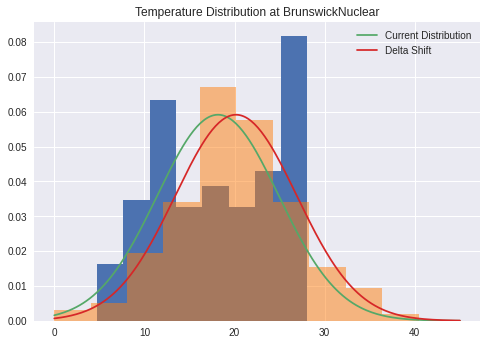

In [7]:
# plot and sample
import scipy.stats as sst

# set random seed
np.random.seed(235)
N = 12*20
fig, ax = plt.subplots()
df.hist(ax=ax,density=True, bins=8)
x = np.linspace(0, 45, N)
y_i = sst.norm.pdf(x, curr_mean, curr_std)
y_shift = sst.norm.pdf(x, curr_mean+delta_shift, curr_std)
s_i = np.random.normal(curr_mean+delta_shift, curr_std, N)
ax.hist(s_i, density=True, color='tab:orange', alpha=0.5)
ax.plot(x, y_i, label='Current Distribution')
ax.plot(x, y_shift, label='Delta Shift', color='tab:red')
ax.set_title(f'Temperature Distribution at {plant_name}')
ax.legend()

## Step 2: Calculate the Stream Temperature at each of the new air temps.

In [8]:
# create model dataframe
model_df = pd.DataFrame({'modeled_air_temps':s_i})
m = stream_model[stream_model['Plant ID'] == pid].m.values[0]
b = stream_model[stream_model['Plant ID'] == pid].b.values[0]

air_to_stream = lambda T: m*T + b

model_df['modeled_stream_temps'] = model_df['modeled_air_temps'].apply(air_to_stream)

In [9]:
model_df.head()

,modeled_air_temps,modeled_stream_temps
0,20.434264,20.936538
1,25.346701,25.734207
2,29.847873,30.130220
3,10.434143,11.170045
4,19.047208,19.581887


## Step 3: Calculate the $\Delta$E at max power and Check if Max Flowrate is Exceeded

In [10]:
plant_data = pd.read_csv(f'energy_balance/energy_balance_plant_{pid}.csv')

In [11]:
plant_data.head(2)

,date,Plant ID,diversion_rate_kgM,withdrawal_rate_kgM,discharge_rate_kgM,consumption_rate_kgM,avg_intake_temp_C,max_intake_temp_C,avg_discharge_temp_C,max_discharge_temp_C,Nameplate Capacity (MW),max_withdrawal_rate_kgM,elc_mmbtu_in,elc_mwh_out,elc_in_kj,elc_out_kj,modeled_discharge_temp,R_combined,temp_limit
0,2016-01-31,6014.0,0.0,6.945383e+10,6.945383e+10,0.0,10.277778,17.500000,31.111111,100.0,2003.2,1.758973e+11,14311933.0,1368449.0,1.510052e+13,4.926416e+12,29.050922,0.464182,34.8
1,2016-02-29,6014.0,0.0,6.138415e+10,6.138415e+10,0.0,8.888889,11.666667,25.833333,86.0,2003.2,1.645491e+11,10505360.0,1004480.0,1.108420e+13,3.616128e+12,24.480452,0.464182,34.8


In [12]:
max_output = plant_data.elc_out_kj.max()
max_input = plant_data.elc_in_kj.max()
deltaE = max_input-max_output
temp_limit = plant_data.temp_limit.values[0]
R = plant_data.R_combined.values[0]
max_withdrawal = plant_data.max_withdrawal_rate_kgM.values[0]

In [13]:
flow_rates = np.zeros(len(model_df))
for i,T_in in enumerate(model_df.modeled_stream_temps):
    flow_rates[i] = calculate_max_flow_rate(R, max_input, max_output, T_in, temp_limit)
#     print(flow_rates[i] > max_withdrawal, T_in)

In [14]:
model_df['flow_rate'] = flow_rates

## Step 4: Calculate the necessary power reduction to be under the temperature limit.

In [15]:
model_df.loc[0, 'flow_rate']

96984767711.95044

In [16]:
threshold = 0.01
N_iter = 100
derate = np.zeros(len(model_df))

reduction_list = np.zeros(len(model_df))
for j in range(len(model_df)):
    flow_rate_exceeded = model_df.loc[j, 'flow_rate'] > max_withdrawal
    reduction_list = np.linspace(0,0.99,N_iter)
#     print(reduction_list)
    new_temps = np.zeros(N_iter)
    for i, r in enumerate(reduction_list):
        if flow_rate_exceeded:
#             print('flowrate exceeded')
            fr = max_withdrawal
        else:
            fr = model_df.loc[j, 'flow_rate']
        
        t_out = calculate_discharge_temp(Rc=R, 
                                         E_in=max_input*r, 
                                         E_out=max_output*r, 
                                         T_in=model_df.loc[j,'modeled_stream_temps'], 
                                         w_in=fr, 
                                         w_out=fr)
        new_temps[i] = t_out
#         print(t_out)
#         print(model_df.loc[j,'modeled_stream_temps'])
#     print(new_temps)
#     print(new_temps[new_temps<=temp_limit])
    try:
        idx = np.argmax(new_temps[new_temps<=temp_limit])
        derate[j] = reduction_list[idx]
#         print(np.argmax(new_temps[new_temps<=temp_limit]))
    except:
        print('Shutdown required')

Shutdown required
Shutdown required
Shutdown required
Shutdown required


In [17]:
model_df['derate'] = derate

In [18]:
model_df.head(2)

,modeled_air_temps,modeled_stream_temps,flow_rate,derate
0,20.434264,20.936538,9.698477e+10,0.99
1,25.346701,25.734207,1.483097e+11,0.99


Text(0.5, 1.0, 'Power Derate at Brunswick Nuclear Due to Climate Change')

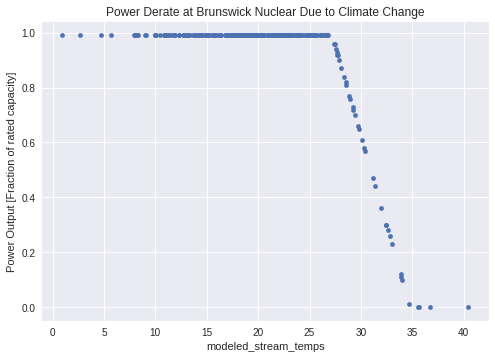

In [22]:
ax = model_df.plot.scatter(x='modeled_stream_temps',y='derate')
ax.set_ylabel('Power Output [Fraction of rated capacity]')
ax.set_title('Power Derate at Brunswick Nuclear Due to Climate Change')

In [20]:
derate.sum()/(N)

0.9190416666666668

In [4]:
"".join(['s','2'])

's2'